# Evaluate BleTIES MILRAA output with simulated ONT R9.5 reads

In [1]:
import json
import re

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from Bio import SeqIO
from Bio import Seq

In [2]:
with open("ref/ptetraurelia_mac_51.min100k_max100N.iescoords.json", "r") as fh:
    iescoords = json.load(fh)

Evaluate the following:

 * Number of IESs recovered vs. MAC+IES average read coverage
  * Thereof: Number with correct coordinate; TA junction; correct length
 * Number of mismatches between assembled IES sequence and vs. MAC+IES average read coverage

In [3]:
# fields to report
# iescov, ID, scaffold, coord, TA, length, score (coord, coord_TA, coord_TA_len)
out = []
for iescov in ['00','05','10','20','40']:
    with open(f"bleties_ont/ptet_sim_ontR95.mix{iescov}.milraa_subreads.milraa_ies.gff3","r") as fh:
        for line in fh:
            if not re.match(r"#", line):
                spl=line.rstrip().split("\t")
                scaff=spl[0]
                coord=spl[3]
                outcoord = coord
                attr=spl[-1].rstrip(";").split(";")
                attrdict={a.split("=")[0]:a.split("=")[1] for a in attr}
                score = "nomatch"
                if "ta_pointer_start" in attrdict and attrdict["ta_pointer_start"] in iescoords[scaff]:
                    outcoord = attrdict["ta_pointer_start"]
                    # Correct coordinate and TA pointer present
                    if int(attrdict["IES_length"]) == iescoords[scaff][attrdict["ta_pointer_start"]]:
                        # Correct coordinate and TA pointer and length
                        score = "coord_TA_len"
                    else:
                        # Correct coordinate and TA pointer but wrong length
                        score = "coord_TA"
                else:
                    if coord in iescoords[scaff]:
                        # Correct coordinate but no TA pointer
                        if int(attrdict["IES_length"]) == iescoords[scaff][coord]:
                            # Correct coordinate and length but no TA pointer
                            score = "coord_len"
                        else:
                            score = "coord"
                    else:
                        for coord_i in range(int(coord)-10, int(coord)+10):
                            if str(coord_i) in iescoords[scaff]:
                                score = "coord_10"
                        for coord_i in range(int(coord)-5, int(coord)+5):
                            if str(coord_i) in iescoords[scaff]:
                                score = "coord_5"
                out.append([iescov, attrdict["ID"], scaff, outcoord, attrdict["IES_length"], score])
out = pd.DataFrame(out, columns=["iescov","ID","scaffold","pos","len","score"])

In [4]:
out.head()

,iescov,ID,scaffold,pos,len,score
0,05,BREAK_POINTS_SUBREADS_scaffold51_100_256802_78,scaffold51_100,256803,78,coord_TA
1,05,BREAK_POINTS_SUBREADS_scaffold51_100_257911_45,scaffold51_100,257911,45,coord_TA_len
2,05,BREAK_POINTS_SUBREADS_scaffold51_100_258619_43,scaffold51_100,258620,43,coord_TA_len
3,05,BREAK_POINTS_SUBREADS_scaffold51_100_258810_74,scaffold51_100,258811,74,coord_TA
4,05,BREAK_POINTS_SUBREADS_scaffold51_100_259946_97,scaffold51_100,259946,97,coord_TA_len


Text(0.5, 1, 'BleTIES MILRAA on simulated Nanopore data')

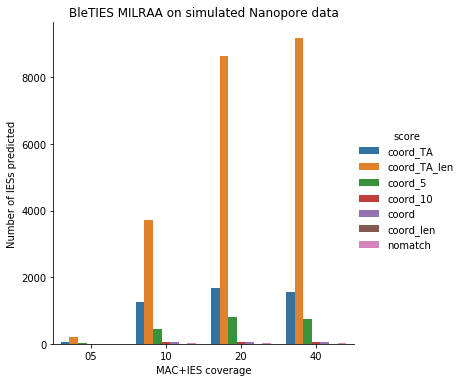

In [5]:
sns.catplot(hue='score',x='iescov',kind='count',data=out)
plt.xlabel("MAC+IES coverage")
plt.ylabel("Number of IESs predicted")
plt.title("BleTIES MILRAA on simulated Nanopore data")

In [6]:
# tabulate by score type and reformat table for barplot
cts = out[['iescov','score']].groupby(['iescov','score']).size().reset_index()
ctsspread = cts.pivot(index='iescov',columns='score',values=0).reset_index().fillna(0)

In [7]:
# Total IESs predicted per mixture ratio
cts.pivot(index='iescov',columns='score',values=0).fillna(0).transpose().sum()

iescov
05      308.0
10     5515.0
20    11276.0
40    11609.0
dtype: float64

In [12]:
# Total IESs predicted per mixture ratio
cts.pivot(index='iescov',columns='score',values=0).fillna(0).transpose()

iescov,05,10,20,40
score,,,,
coord,1.0,41.0,53.0,42.0
coord_10,2.0,43.0,66.0,67.0
coord_5,29.0,439.0,805.0,735.0
coord_TA,69.0,1245.0,1679.0,1545.0
coord_TA_len,207.0,3726.0,8645.0,9188.0
coord_len,0.0,8.0,6.0,1.0
nomatch,0.0,13.0,22.0,31.0


In [8]:
ctsspread

score,iescov,coord,coord_10,coord_5,coord_TA,coord_TA_len,coord_len,nomatch
0,05,1.0,2.0,29.0,69.0,207.0,0.0,0.0
1,10,41.0,43.0,439.0,1245.0,3726.0,8.0,13.0
2,20,53.0,66.0,805.0,1679.0,8645.0,6.0,22.0
3,40,42.0,67.0,735.0,1545.0,9188.0,1.0,31.0


In [9]:
ctsspread.to_csv("plots/ptet_sim_ontR95.mix.ies_results.tsv", sep="\t", index=False)

In [10]:
# Total number of IESs in the input
sum([len(iescoords[scaff]) for scaff in iescoords])

12199

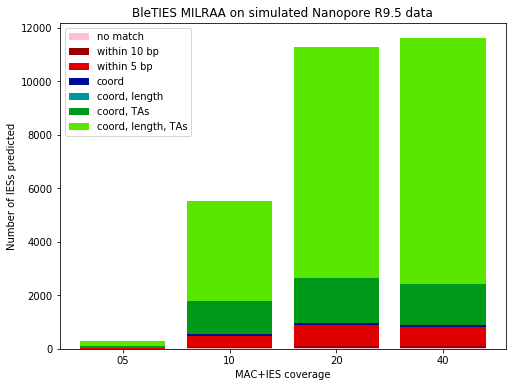

In [11]:
plt.figure(figsize=(8,6))
plt.bar(ctsspread['iescov'], ctsspread['nomatch'], label='no match', color='pink')
plt.bar(ctsspread['iescov'], ctsspread['coord_10'], label='within 10 bp', color='#9a0000',
        bottom = ctsspread['nomatch'])
plt.bar(ctsspread['iescov'], ctsspread['coord_5'], label='within 5 bp', color='#e10000',
        bottom = ctsspread['nomatch'] + ctsspread['coord_10'])
plt.bar(ctsspread['iescov'],ctsspread['coord'], label='coord', color='#000a9a',
        bottom = ctsspread['nomatch'] + ctsspread['coord_10'] + ctsspread['coord_5'])
plt.bar(ctsspread['iescov'],ctsspread['coord_len'], label='coord, length', color='#00969a',
        bottom = ctsspread['nomatch'] + ctsspread['coord_10'] + ctsspread['coord_5'] + ctsspread['coord'])
plt.bar(ctsspread['iescov'],ctsspread['coord_TA'], label='coord, TAs', color='#009a1a',
        bottom = ctsspread['nomatch'] + ctsspread['coord_10'] + ctsspread['coord_5'] + ctsspread['coord'] + ctsspread['coord_len'])
plt.bar(ctsspread['iescov'],ctsspread['coord_TA_len'], label='coord, length, TAs', color='#59e700',
        bottom = ctsspread['nomatch'] + ctsspread['coord_10'] + ctsspread['coord_5'] + ctsspread['coord'] + ctsspread['coord_len'] + ctsspread['coord_TA'])
plt.legend()
plt.xlabel("MAC+IES coverage")
plt.ylabel("Number of IESs predicted")
plt.title("BleTIES MILRAA on simulated Nanopore R9.5 data")
plt.savefig("plots/ptet_sim_ontR95.mix.ies_results.png")
plt.savefig("plots/ptet_sim_ontR95.mix.ies_results.pdf")

In [14]:
ieslens = []
for scaff in iescoords:
    ieslens.extend(iescoords[scaff].values())

In [13]:
out.head()

,iescov,ID,scaffold,pos,len,score
0,05,BREAK_POINTS_SUBREADS_scaffold51_100_257911_45,scaffold51_100,257911,45,coord_TA_len
1,05,BREAK_POINTS_SUBREADS_scaffold51_100_258810_74,scaffold51_100,258811,74,coord_TA
2,05,BREAK_POINTS_SUBREADS_scaffold51_100_259946_96,scaffold51_100,259946,96,coord_TA
3,05,BREAK_POINTS_SUBREADS_scaffold51_100_261542_68,scaffold51_100,261543,68,coord_TA_len
4,05,BREAK_POINTS_SUBREADS_scaffold51_100_263756_44,scaffold51_100,263757,44,coord_TA_len


In [15]:
out['len'] = pd.to_numeric(out['len'])

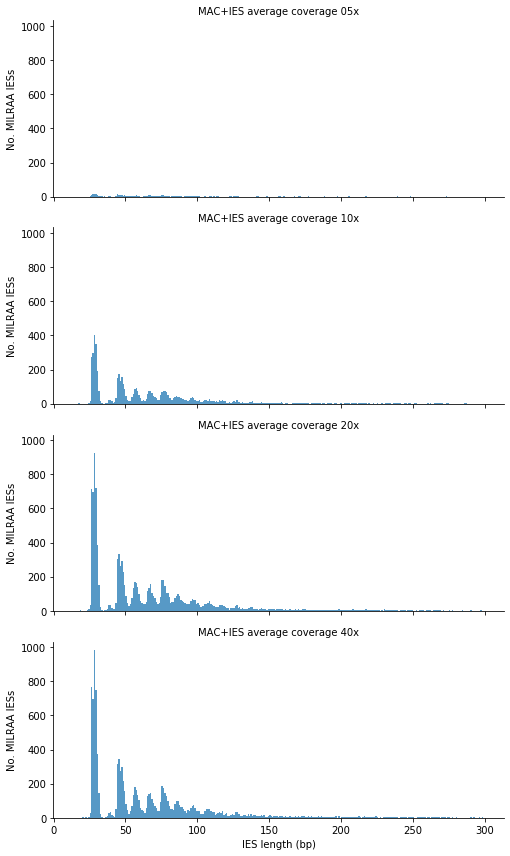

In [17]:
grid = sns.FacetGrid(out.query('len<300'), row='iescov', height=3, aspect=7/3)
grid.map(sns.histplot, 'len', binwidth=1, linewidth=0)
grid.set_titles(row_template="MAC+IES average coverage {row_name}x")
grid.set_xlabels("IES length (bp)")
grid.set_ylabels("No. MILRAA IESs")
grid.savefig("plots/ptet_sim_ontR95.mix.ieslengths.png")
grid.savefig("plots/ptet_sim_ontR95.mix.ieslengths.pdf")

# Compare reconstructed IES seqs with original

Extract IES sequences from MAC+IES assembly

In [18]:
macies = SeqIO.to_dict(SeqIO.parse("ref/ptetraurelia_mac_51_with_ies.min100k_max100N.fa","fasta"))

In [19]:
iesrecon = {}
for cov in ['05','10','20','40']:
    iesrecon[cov] = SeqIO.to_dict(
        SeqIO.parse(
            f"bleties_ont/ptet_sim_ontR95.mix{cov}.milraa_subreads.milraa_ies.fasta","fasta"))

In [20]:
with open("ref/ptetraurelia_mac_51_with_ies.min100k_max100N.iescoords.json", "r") as fh:
    iescoords_orig = json.load(fh)

In [21]:
from Bio import pairwise2
from collections import defaultdict

In [22]:
# Extract original IESs from the MAC+IES assembly
orig_ies_seqs = defaultdict(dict)
for scaff in iescoords_orig:
    scaff_mac = scaff[:-9]
    # dict of new coordinate vs. original coordinates
    new_old = dict(zip(iescoords[scaff_mac],iescoords_orig[scaff]))
    for pos in new_old:
        name = 'ies_' + scaff_mac + "_" + str(pos)
        orig_ies_seqs[scaff_mac][pos] = macies[scaff][new_old[pos][0]:new_old[pos][1]]

In [23]:
# Compare original and reconstructed IES sequences
iescomp = []
for cov in iesrecon:
    for seqid in iesrecon[cov]:
        spl = seqid.split("_")
        scaff = "_".join(spl[3:5])
        pos = str(spl[5])
        if pos in orig_ies_seqs[scaff]:
            origlen = len(orig_ies_seqs[scaff][pos].seq[:-2])
            assemlen = len(iesrecon[cov][seqid].seq)
            # define percent identity as number of matching bases 
            # in whichever is longer: original seq or consensus
            alnscore = (pairwise2.align.globalxx(
                str(orig_ies_seqs[scaff][pos].seq[:-2]).upper(),
                iesrecon[cov][seqid].seq,
                score_only=True))
            pid = alnscore / max([origlen, assemlen])
            mismatch = int(origlen - alnscore)
            indel = int(assemlen - origlen)
            iescomp.append([cov, seqid, pid, mismatch, indel])

In [24]:
iescomp_tbl = pd.DataFrame(iescomp, columns=['cov','seqid','pid','mm','indel'])

In [25]:
iescomp_tbl.head()

,cov,seqid,pid,mm,indel
0,05,BREAK_POINTS_SUBREADS_scaffold51_151_93367_47,1.000000,0,0
1,05,BREAK_POINTS_SUBREADS_scaffold51_151_93669_30,1.000000,0,0
2,05,BREAK_POINTS_SUBREADS_scaffold51_151_93912_69,1.000000,0,0
3,05,BREAK_POINTS_SUBREADS_scaffold51_103_243667_96,0.989691,1,-1
4,05,BREAK_POINTS_SUBREADS_scaffold51_61_266762_74,0.973684,2,-2


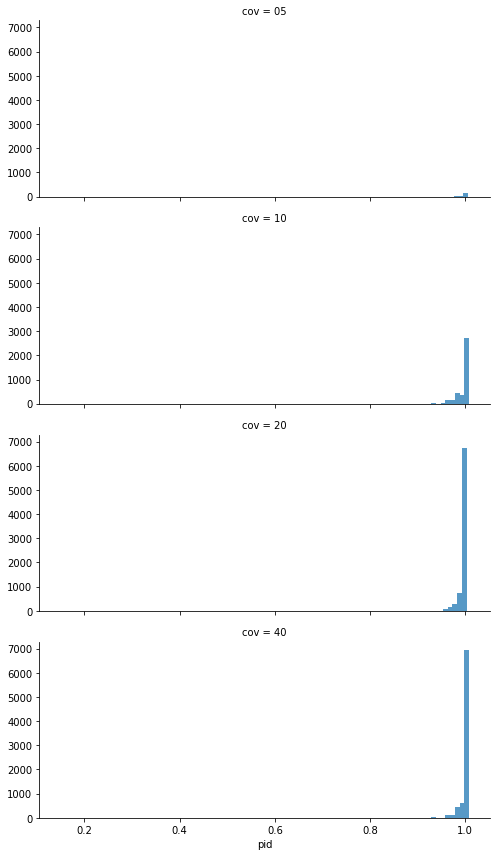

In [29]:
grid = sns.FacetGrid(iescomp_tbl, row='cov', height=3, aspect=7/3)
grid.map(sns.histplot, 'pid', binwidth=0.01, linewidth=0)
plt.savefig("plots/ptet_sim_ontR95.mix.ies_vs_orig_seqid.png")
plt.savefig("plots/ptet_sim_ontR95.mix.ies_vs_orig_seqid.pdf")

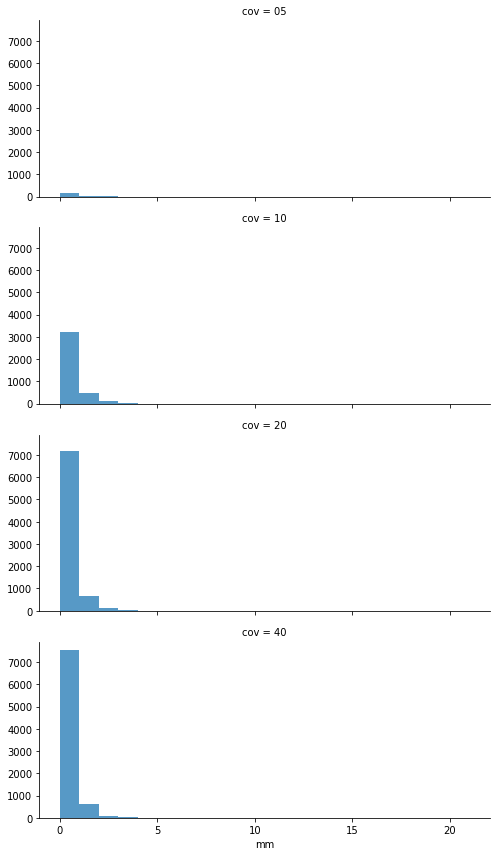

In [28]:
grid = sns.FacetGrid(iescomp_tbl.query('mm < 25'), row='cov', height=3, aspect=7/3)
grid.map(sns.histplot, 'mm', binwidth=1, linewidth=0)
plt.savefig("plots/ptet_sim_ontR95.mix.ies_vs_orig_mm.png")
plt.savefig("plots/ptet_sim_ontR95.mix.ies_vs_orig_mm.pdf")

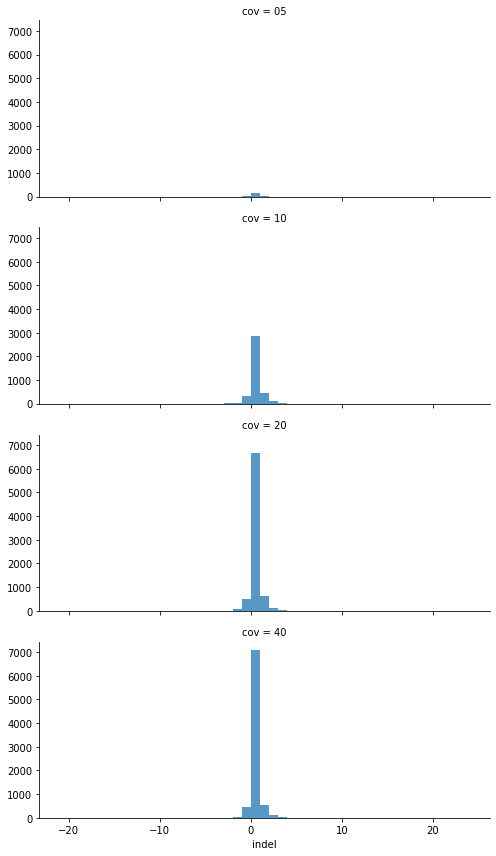

In [30]:
grid = sns.FacetGrid(iescomp_tbl.query('indel > -25 & indel < 25'), row='cov', height=3, aspect=7/3)
grid.map(sns.histplot, 'indel', binwidth=1, linewidth=0)
plt.savefig("plots/ptet_sim_ontR95.mix.ies_vs_orig_indel.png")
plt.savefig("plots/ptet_sim_ontR95.mix.ies_vs_orig_indel.pdf")

In [32]:
for cov in ['05','10','20','40']:
    print(cov)
    print(iescomp_tbl.query(f"cov == '{cov}'").quantile([1, 0.99, 0.98, 0.97, 0.96, 0.95], axis=0))
    print("")

05
      pid    mm  indel
1.00  1.0  51.0    2.0
0.99  1.0   2.0    2.0
0.98  1.0   2.0    2.0
0.97  1.0   2.0    1.7
0.96  1.0   1.6    1.0
0.95  1.0   1.0    1.0

10
      pid    mm  indel
1.00  1.0  44.0   59.0
0.99  1.0   3.0    2.0
0.98  1.0   2.0    2.0
0.97  1.0   2.0    2.0
0.96  1.0   1.0    1.0
0.95  1.0   1.0    1.0

20
      pid     mm  indel
1.00  1.0  153.0   81.0
0.99  1.0    2.0    2.0
0.98  1.0    1.8    1.0
0.97  1.0    1.0    1.0
0.96  1.0    1.0    1.0
0.95  1.0    1.0    1.0

40
      pid    mm  indel
1.00  1.0  45.0   80.0
0.99  1.0   2.0    2.0
0.98  1.0   1.0    1.0
0.97  1.0   1.0    1.0
0.96  1.0   1.0    1.0
0.95  1.0   1.0    1.0



In [33]:
with open("plots/ptet_sim_ontR95.mix.seqid_summary.tsv", "w") as fh:
    # Print header
    fh.write("\t".join(['cov','total','id 100','id 97','mm 0','mm 1','indel 0','indel 1', 'mm indel 1']))
    fh.write("\n")
    for cov in ['05','10','20','40']:
        fh.write("\t".join([
            cov,
            str(iescomp_tbl.query(f"cov == '{cov}'").shape[0]),
            str(iescomp_tbl.query(f"cov == '{cov}' & pid == 1.0").shape[0]),
            str(iescomp_tbl.query(f"cov == '{cov}' & pid > 0.97").shape[0]),
            str(iescomp_tbl.query(f"cov == '{cov}' & mm == 0").shape[0]),
            str(iescomp_tbl.query(f"cov == '{cov}' & mm <= 1").shape[0]),
            str(iescomp_tbl.query(f"cov == '{cov}' & indel == 0").shape[0]),
            str(iescomp_tbl.query(f"cov == '{cov}' & indel >= -1 & indel <= 1").shape[0]),
            str(iescomp_tbl.query(f"cov == '{cov}' & indel >= -1 & indel <= 1 & mm <= 1").shape[0])
        ]))
        fh.write("\n")

In [35]:
cat plots/ptet_sim_ontR95.mix.seqid_summary.tsv

cov	total	id 100	id 97	mm 0	mm 1	indel 0	indel 1	mm indel 1
05	211	139	199	165	202	150	200	195
10	3860	2714	3631	3214	3709	2878	3661	3584
20	8011	6499	7756	7199	7850	6670	7774	7703
40	8306	6929	8104	7543	8173	7093	8085	8035


In [13]:
pd.read_csv("plots/ptet_sim_ontR95.mix.seqid_summary.tsv", sep="\t").transpose()

,0,1,2,3
cov,5,10,20,40
total,211,3860,8011,8306
id 100,139,2714,6499,6929
id 97,199,3631,7756,8104
mm 0,165,3214,7199,7543
mm 1,202,3709,7850,8173
indel 0,150,2878,6670,7093
indel 1,200,3661,7774,8085
mm indel 1,195,3584,7703,8035
